# Applied Deep Learning Assignment Task 1
`Name: Gangula Karthik`<br>
`Admin_no: 223715Y`

---

_**Develop and compare deep learning and transfer learning models for early brain tumor detection and classification to optimize treatment selection and improve patient outcomes.**_

---


## Table of Contents
1. [Introduction](#Introduction)
1. [Setup](#Setup)
1. [Data Validation and Cleaning](#Data-Validation-and-Cleaning)
1. [Train Test Split](#Train-Test-Split)
1. [Numerical EDA](#Numerical-EDA)
1. [Graphical EDA](#Graphical-EDA)
1. [Feature Engineering](#Feature-Engineering)
1. [Data Preprocessing](#Data-Preprocessing)
1. [Baseline Model](#Baseline-Model)
1. [Model Building, Selection, and Evaluation](#Model-Building-Selection-and-Evaluation)
1. [Baseline Model Comparison](#Baseline-Model-Comparison)
1. [Final Model Evaluation](#Final-Model-Evaluation)
1. [Conclusion](#Conclusion)
1. [Appendix](#Appendix)

---


### Introduction

Brain tumors are abnormal growths within or around the brain that can be malignant or benign, requiring accurate and early diagnosis for effective treatment. Distinguishing brain tumors from other cystic or tumor-like growths in MRI scans remains a significant challenge in medical imaging. Advanced deep learning techniques offer the potential to enhance early detection and diagnosis, reducing misclassification and improving patient outcomes. Based on their location and origin, brain tumors can be categorized into types such as Gliomas, which originate in the brain or spinal cord; Meningiomas, arising from the protective membranes (meninges) surrounding the brain and spinal cord; and Pituitary Tumors, which develop in the pituitary gland. Developing deep learning-based models to differentiate between these tumor types and similar-appearing cysts in MRI scans is crucial for guiding timely and appropriate treatment strategies.

---

### Setup

Import all the Python libraries we will need

---

In [1]:
# !pip install tensorflow-addons

In [2]:
# Add imports here
import itertools
import pandas as pd
import cv2
import random
from ydata_profiling import ProfileReport
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import os
import scipy.stats
import tensorflow as tf
from tqdm import tqdm
import phik
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm 

### Loading the datasets

Parsing the folders and putting them in a dataframe.

---

In [3]:
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"
train_dir = os.path.join(dataset_path, "Training")
test_dir = os.path.join(dataset_path, "Testing")

In [4]:
def create_dataframe(directory):
    data = []
    for label in os.listdir(directory): 
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):  
            for img_file in os.listdir(label_path):  
                img_path = os.path.join(label_path, img_file)
                data.append((img_path, label))
    return pd.DataFrame(data, columns=["file_path", "label"])

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

In [5]:
display("Train DataFrame:", train_df.head())
display("Test DataFrame:", test_df.head())

'Train DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Training...  pituitary

'Test DataFrame:'

file_path      label
0  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
1  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
2  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
3  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary
4  /kaggle/input/brain-tumor-mri-dataset/Testing/...  pituitary

### Data Understanding

Analysing the data in depth in order to understand the data and how to apply different transformations. 

---

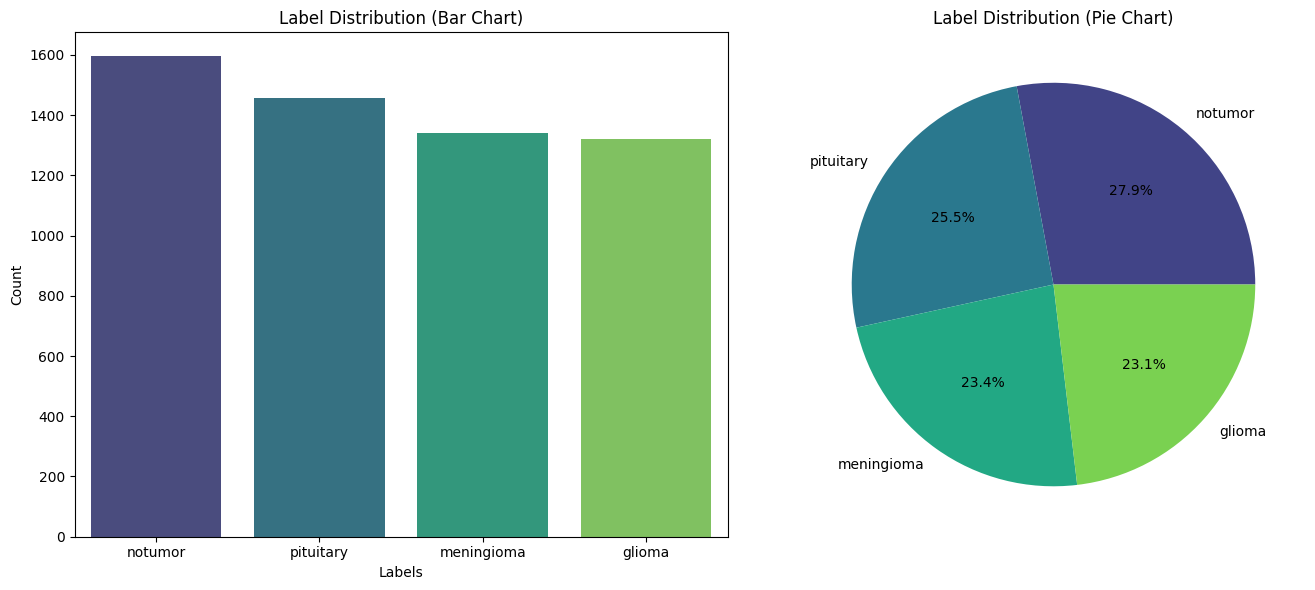

In [6]:
label_counts = train_df["label"].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=label_counts.index, y=label_counts.values, ax=axes[0], palette="viridis")
axes[0].set_title("Label Distribution (Bar Chart)")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x")

axes[1].pie(label_counts, labels=label_counts.index, autopct="%1.1f%%", colors=sns.color_palette("viridis", len(label_counts)))
axes[1].set_title("Label Distribution (Pie Chart)")

plt.tight_layout()
plt.show()

In [7]:
def get_image_size(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        return img.shape[1], img.shape[0]
    return None, None 

train_df["width"], train_df["height"] = zip(*train_df["file_path"].apply(get_image_size))

train_df["aspect_ratio"] = train_df["width"] / train_df["height"]

train_df[["width", "height", "aspect_ratio"]].describe()

width       height  aspect_ratio
count  5712.000000  5712.000000   5712.000000
mean    451.563200   453.883754      0.994201
std     131.004291   124.779164      0.109435
min     150.000000   168.000000      0.644809
25%     441.000000   442.000000      1.000000
50%     512.000000   512.000000      1.000000
75%     512.000000   512.000000      1.000000
max    1920.000000  1446.000000      1.785714

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


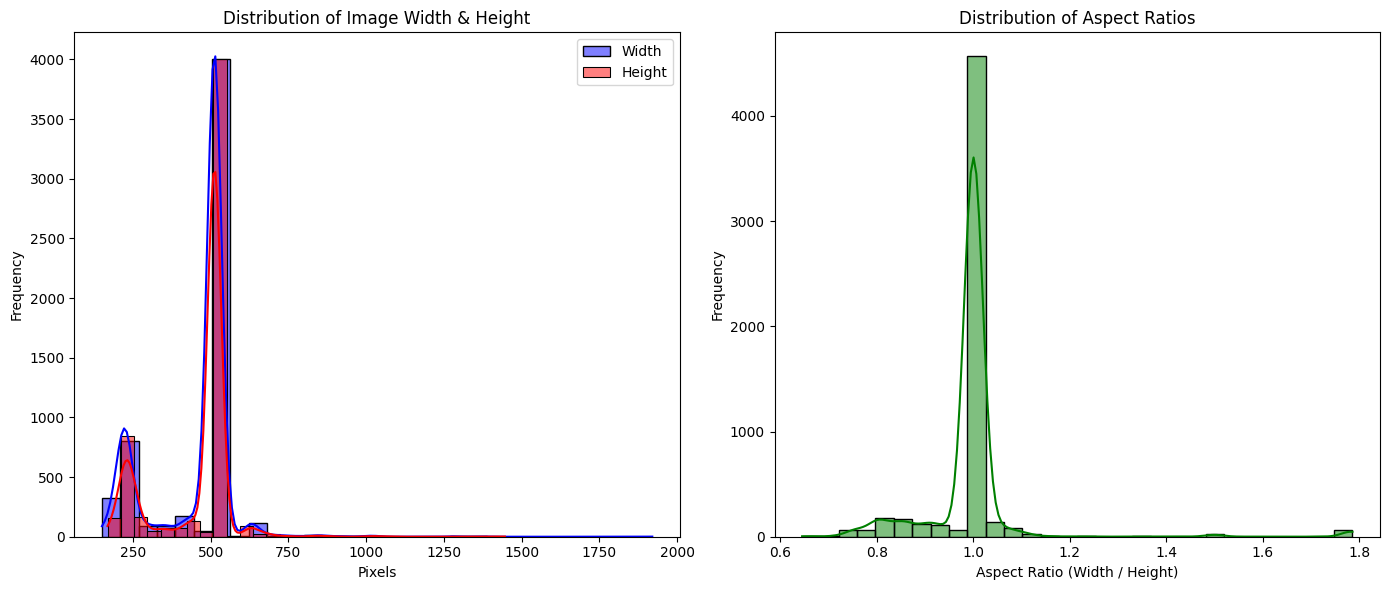

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# histogram of the image sizes
sns.histplot(train_df["width"], bins=30, kde=True, ax=axes[0], color="blue", label="Width")
sns.histplot(train_df["height"], bins=30, kde=True, ax=axes[0], color="red", label="Height")
axes[0].set_title("Distribution of Image Width & Height")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# histogram of the aspect ratio
sns.histplot(train_df["aspect_ratio"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribution of Aspect Ratios")
axes[1].set_xlabel("Aspect Ratio (Width / Height)")
axes[1].set_ylabel("Frequency")

# Show plots
plt.tight_layout()
plt.show()

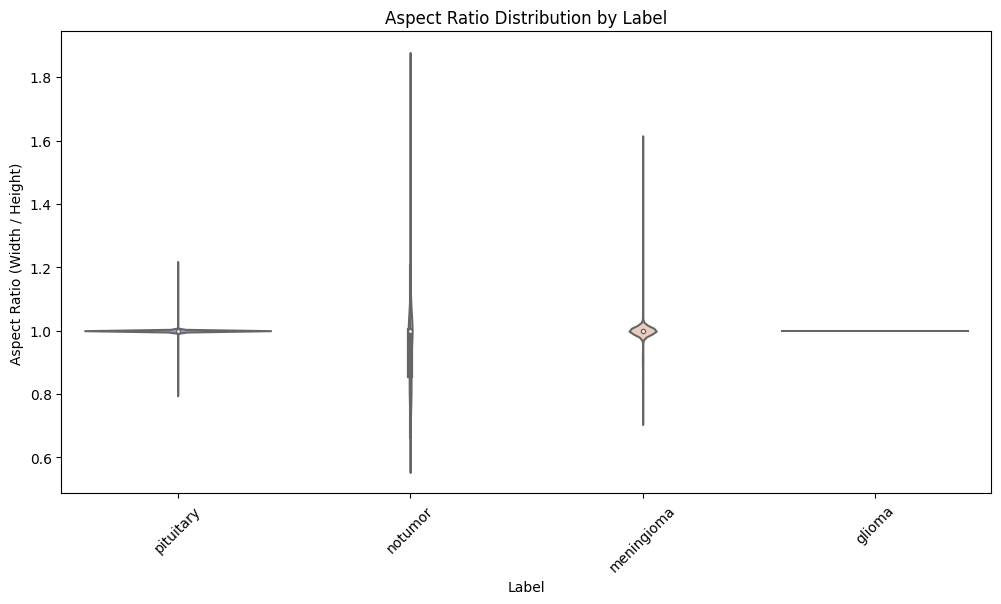

In [9]:
plt.figure(figsize=(12, 6))

sns.violinplot(x=train_df["label"], y=train_df["aspect_ratio"], palette="coolwarm")

plt.title("Aspect Ratio Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Aspect Ratio (Width / Height)")
plt.xticks(rotation=45)

plt.show()

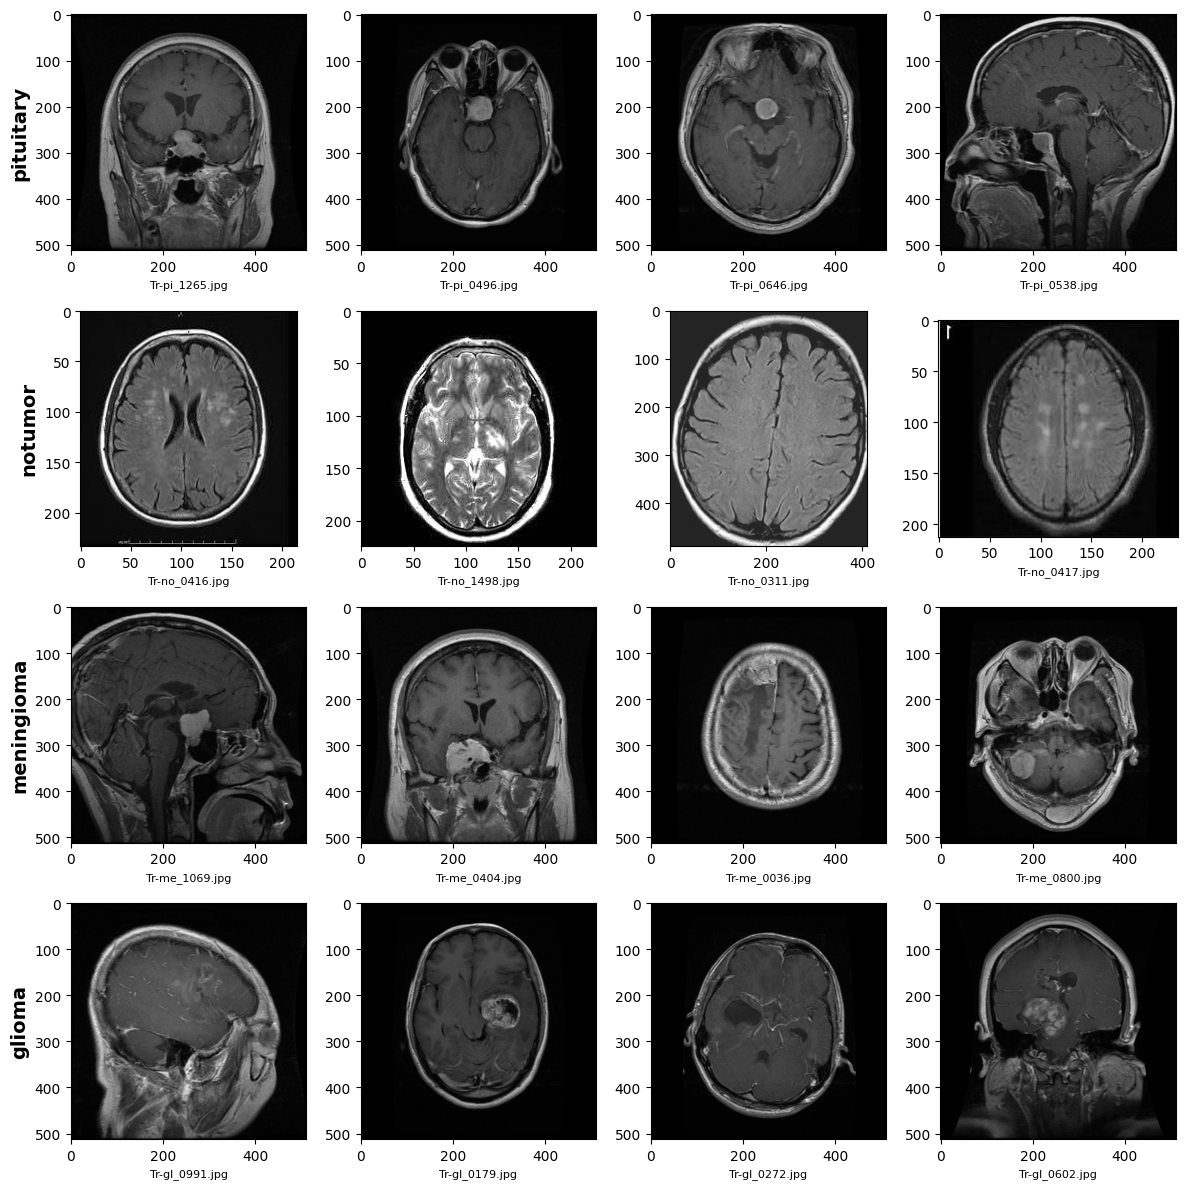

In [10]:
selected_labels = train_df["label"].unique()[:4]
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

for row, label in enumerate(selected_labels):
    sample_paths = random.sample(train_df[train_df["label"] == label]["file_path"].tolist(), 4)
    
    for col, sample_path in enumerate(sample_paths):
        img = cv2.imread(sample_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        ax = axes[row, col]
        ax.imshow(img)
        
        if col == 0:
            ax.set_ylabel(label, fontsize=14, fontweight="bold") 
        
        img_name = os.path.basename(sample_path)
        ax.set_xlabel(img_name, fontsize=8, color="black")

plt.tight_layout()
plt.show()

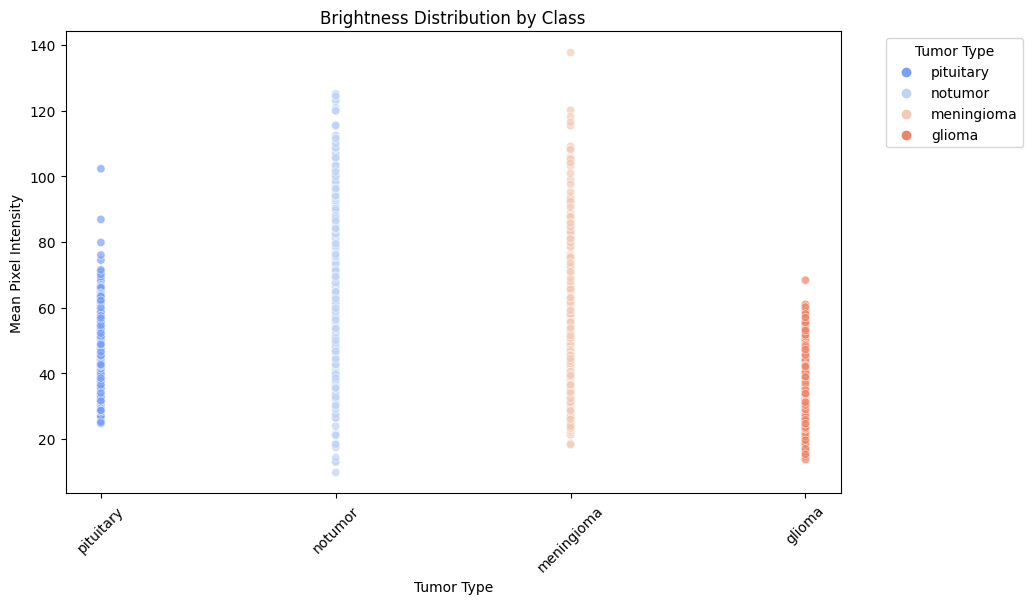

In [11]:
def compute_brightness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.mean(img) if img is not None else None

train_df["brightness"] = train_df["file_path"].apply(compute_brightness)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_df["label"], y=train_df["brightness"], alpha=0.7, hue=train_df["label"], palette="coolwarm")
plt.title("Brightness Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Mean Pixel Intensity")
plt.xticks(rotation=45)
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

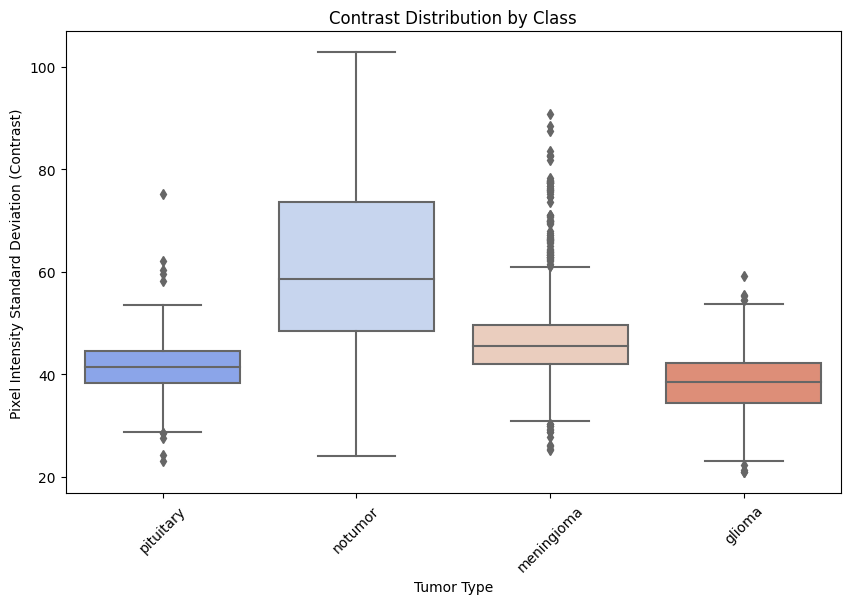

In [12]:
def compute_contrast(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.std(img) if img is not None else None

train_df["contrast"] = train_df["file_path"].apply(compute_contrast)

plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df["label"], y=train_df["contrast"], palette="coolwarm")

plt.title("Contrast Distribution by Class")
plt.xlabel("Tumor Type")
plt.ylabel("Pixel Intensity Standard Deviation (Contrast)")
plt.xticks(rotation=45)
plt.show()

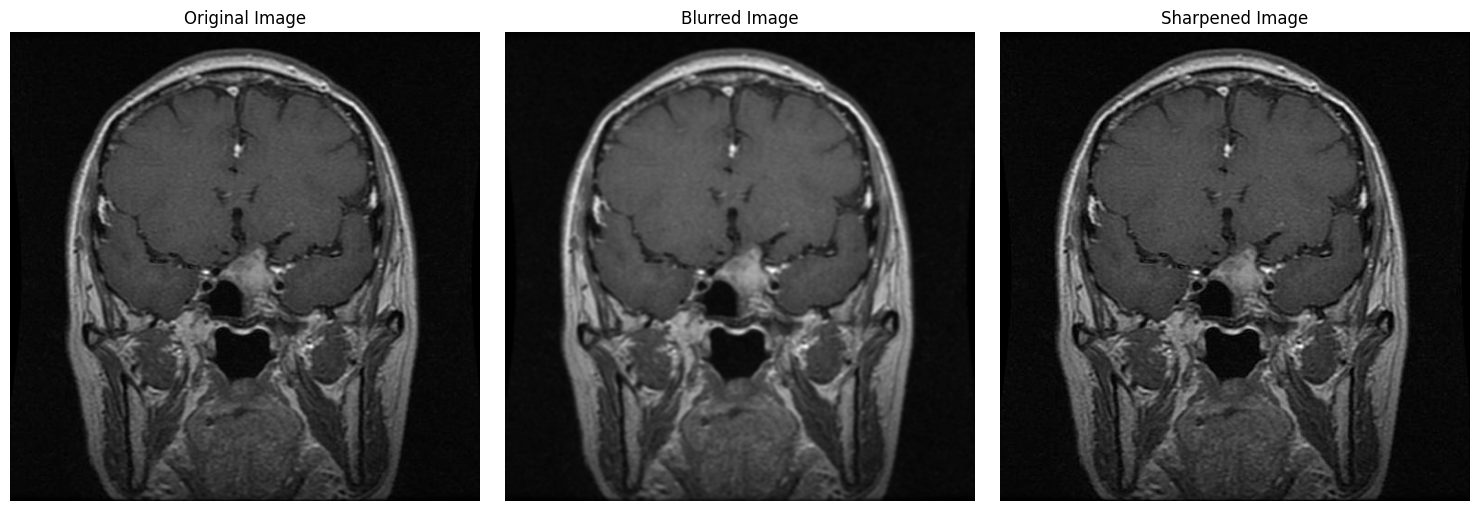

In [13]:
# image processing techniques

image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path)

# Convert to grayscale for easier processing
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur
blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)

# Subtract the blurred image from the original (sharpening)
sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

# Plot the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(img_gray, cmap='gray')
axes[0].set_title("Original Image")
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred Image")
axes[2].imshow(sharpened, cmap='gray')
axes[2].set_title("Sharpened Image")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

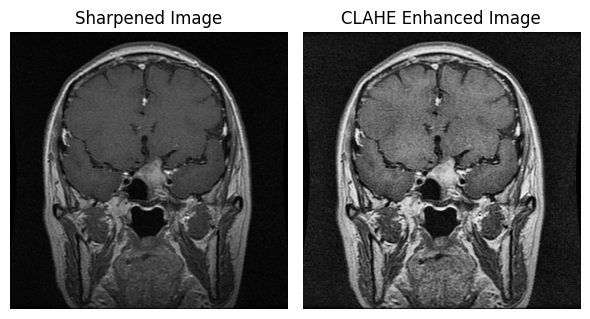

In [14]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
img_clahe = clahe.apply(sharpened)

# Plot the results
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.imshow(sharpened, cmap='gray')
plt.title("Sharpened Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_clahe, cmap='gray')
plt.title("CLAHE Enhanced Image")
plt.axis('off')

plt.tight_layout()
plt.show()

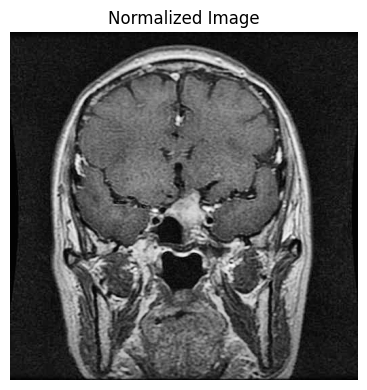

In [15]:
def z_score_normalization(mri_image):
    return (mri_image - np.mean(mri_image)) / np.std(mri_image)


normalized_img = z_score_normalization(img_clahe)

plt.figure(figsize=(12, 4))
plt.imshow(normalized_img, cmap='gray')
plt.title("Normalized Image")
plt.axis('off')

plt.tight_layout()
plt.show()

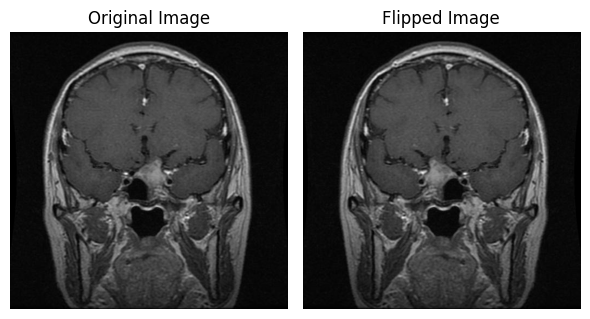

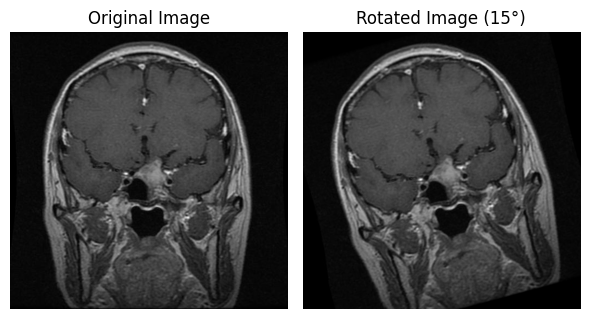

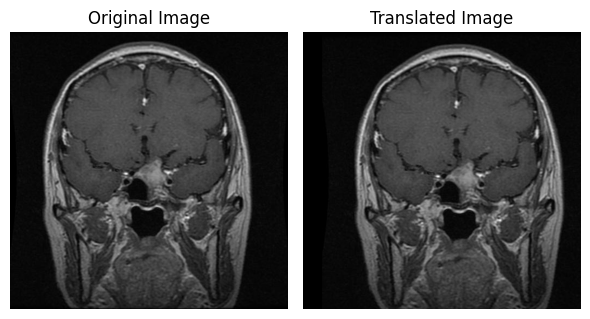

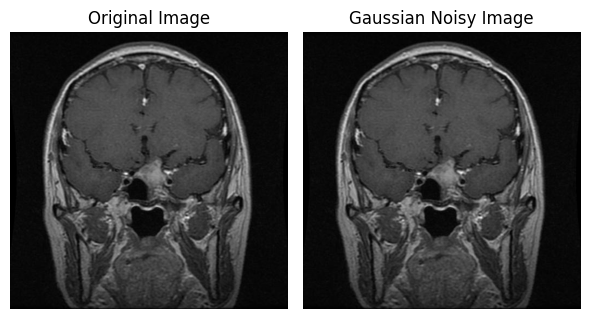

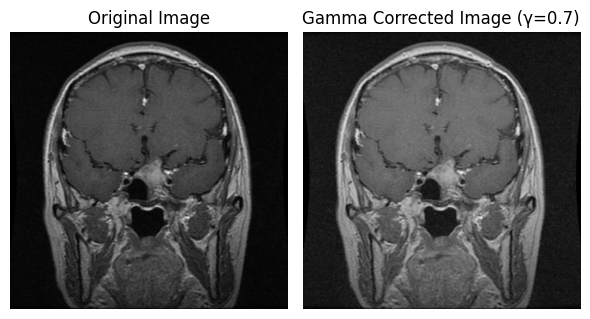

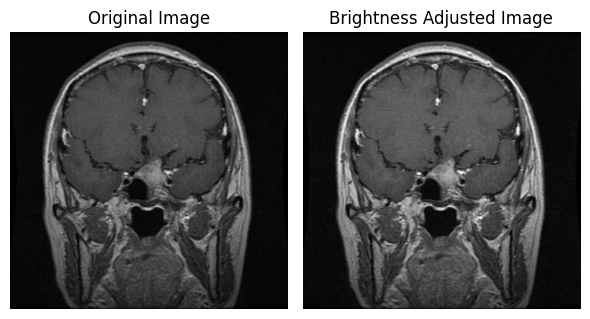

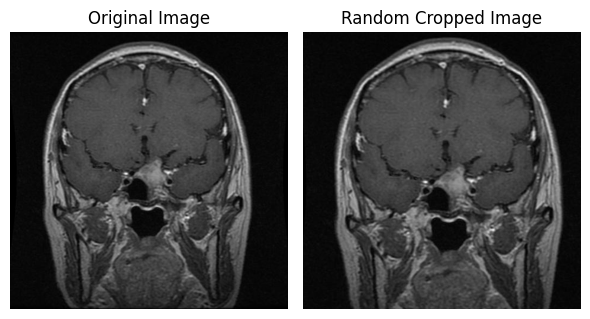

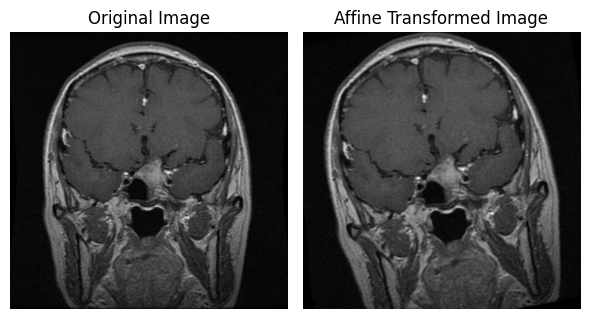

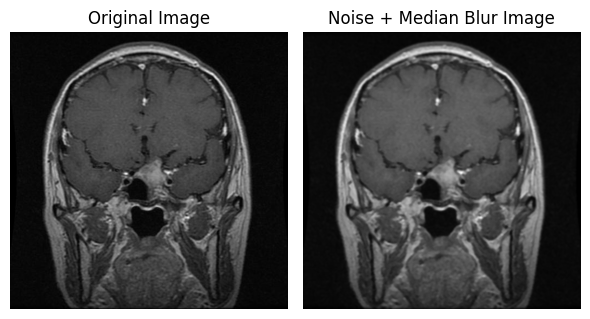

In [16]:
# Load MRI image (replace with your image path)
image_path = train_df.iloc[1, 0]
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Function to visualize transformations
def visualize_single_transformation(original, transformed, title):
    plt.figure(figsize=(6, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(transformed, cmap='gray')
    plt.title(title)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

### 1️⃣ Horizontal Flip ###
flipped = cv2.flip(img, 1)  # 1 means horizontal flip
visualize_single_transformation(img, flipped, "Flipped Image")

### 2️⃣ Rotation (±15 degrees) ###
angle = 15  # 15 degrees rotation
(h, w) = img.shape
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(img, M, (w, h))
visualize_single_transformation(img, rotated, "Rotated Image (15°)")

### 3️⃣ Translation (10% random shift) ###
tx, ty = np.random.randint(-int(w*0.1), int(w*0.1)), np.random.randint(-int(h*0.1), int(h*0.1))
M_translation = np.float32([[1, 0, tx], [0, 1, ty]])
translated = cv2.warpAffine(img, M_translation, (w, h))
visualize_single_transformation(img, translated, "Translated Image")

### 4️⃣ Gaussian Noise (σ=0.03) ###
noise = np.random.normal(0, 0.05, img.shape).astype(np.uint8)
gaussian_noisy = cv2.add(img, noise)
visualize_single_transformation(img, gaussian_noisy, "Gaussian Noisy Image")

### 5️⃣ Gamma Correction (γ=0.7) ###
gamma_corrected = np.array(255 * (img / 255) ** 0.7, dtype='uint8')
visualize_single_transformation(img, gamma_corrected, "Gamma Corrected Image (γ=0.7)")

### 6️⃣ Brightness Adjustment ###
brightness_factor = 40  # You can modify this to increase/decrease brightness
bright_img = cv2.add(img, brightness_factor)  # Increase brightness by adding constant value
visualize_single_transformation(img, bright_img, "Brightness Adjusted Image")

### 7️⃣ Random Cropping (85-95% ROI) ###
crop_size = np.random.randint(int(0.85 * img.shape[0]), int(0.95 * img.shape[0]))
crop_x = np.random.randint(0, img.shape[1] - crop_size)
crop_y = np.random.randint(0, img.shape[0] - crop_size)
cropped = img[crop_y:crop_y+crop_size, crop_x:crop_x+crop_size]
visualize_single_transformation(img, cropped, "Random Cropped Image")

### 8️⃣ Affine Stack (Rotation + Shift + Scale) ###
scale_factor = np.random.uniform(0.9, 1.1)
M_affine = cv2.getRotationMatrix2D(center, 10, scale_factor)
affine_transformed = cv2.warpAffine(img, M_affine, (w, h))
visualize_single_transformation(img, affine_transformed, "Affine Transformed Image")

### 9️⃣ Noise + Blur (Gaussian Noise + Median 3x3) ###
blurred = cv2.GaussianBlur(gaussian_noisy, (5, 5), 0)
median_blurred = cv2.medianBlur(blurred, 3)
visualize_single_transformation(img, median_blurred, "Noise + Median Blur Image")

### Data Preparation

---

In [31]:
import tensorflow as tf
import cv2
import numpy as np
from tqdm import tqdm

def preprocess_image(image_path):
    """Load and preprocess a single image efficiently"""
    # Convert EagerTensor to string properly
    image_path = tf.compat.as_str_any(image_path.numpy())

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Failed to load image: {image_path}")

    img_resized = resize_with_aspect_ratio(img, 224, 224)

    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

    blurred = cv2.GaussianBlur(img_gray, (5, 5), 0)
    sharpened = cv2.addWeighted(img_gray, 1.5, blurred, -0.5, 0)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(cv2.cvtColor(sharpened, cv2.COLOR_BGR2GRAY))
    img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)

    normalized_img = (img_clahe - np.mean(img_clahe)) / (np.std(img_clahe) + 1e-8)
    normalized_img = normalized_img / 255.0  # Normalize

    return normalized_img.astype(np.float32)


def resize_with_aspect_ratio(img, target_height, target_width):
    """ Resize image while keeping aspect ratio """
    original_height, original_width = img.shape[:2]
    aspect_ratio = original_width / original_height
    
    if aspect_ratio > 1:
        new_width = target_width
        new_height = int(target_width / aspect_ratio)
    else:
        new_height = target_height
        new_width = int(target_height * aspect_ratio)
    
    img_resized = cv2.resize(img, (new_width, new_height))
    return cv2.resize(img_resized, (target_width, target_height))


def process_tf_image(image_path, label, num_classes):
    """ TensorFlow wrapper for image processing """
    image = tf.py_function(func=preprocess_image, inp=[image_path], Tout=tf.float32)
    image.set_shape((224, 224, 3))  # Ensure TensorFlow knows the shape
    label = tf.one_hot(label, depth=num_classes, dtype=tf.float32)
    return image, label


def load_and_preprocess_from_df(df, num_classes, batch_size=32):
    """ Load dataset efficiently using TensorFlow pipelines """
    file_paths = df['file_path'].values
    labels = df['label'].values

    unique_labels = sorted(df['label'].unique())
    label_to_index = {label: i for i, label in enumerate(unique_labels)}
    int_labels = np.array([label_to_index[label] for label in labels], dtype=np.int32)

    dataset = tf.data.Dataset.from_tensor_slices((file_paths, int_labels))

    # Use .map() to process images on the fly
    dataset = dataset.map(lambda x, y: process_tf_image(x, y, num_classes),
                          num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset, label_to_index

In [32]:
train_dataset, _ = load_and_preprocess_from_df(train_df, 4)
train_dataset = train_dataset.shuffle(buffer_size=1000).prefetch(tf.data.AUTOTUNE)

### Simple CNN Model

---

In [33]:
import tensorflow as tf

def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # ✅ CNN Feature Extraction with Batch Normalization
    x = tf.keras.layers.Conv2D(32, (3,3), activation=None, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, (3,3), activation=None, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(128, (3,3), activation=None, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    
    outputs = tf.keras.layers.Dense(4, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model


model = build_model(input_shape=(224, 224, 3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_12 (ReLU)                      │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_13 (ReLU)                      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_14 (ReLU)                      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_15 (ReLU)                      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 12,940,356 (49.36 MB)

 Trainable params: 12,939,652 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

val_size = int(0.2 * len(train_dataset))

train_dataset = train_dataset.skip(val_size)
val_dataset = train_dataset.take(val_size)

train_dataset = train_dataset.prefetch(AUTOTUNE)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [53]:
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training after 3 epochs of no improvement
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)


model = build_model(input_shape=(224, 224, 3))

In [42]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 62s 249ms/step - accuracy: 0.2726 - loss: 1.8109 - val_accuracy: 0.2571 - val_loss: 1.6456
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 54s 224ms/step - accuracy: 0.3613 - loss: 1.4886 - val_accuracy: 0.3650 - val_loss: 1.5355
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 53s 217ms/step - accuracy: 0.4242 - loss: 1.3509 - val_accuracy: 0.2464 - val_loss: 1.6633
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 204ms/step - accuracy: 0.4637 - loss: 1.2638 - val_accuracy: 0.2670 - val_loss: 1.5313
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 199ms/step - accuracy: 0.5082 - loss: 1.1746 - val_accuracy: 0.3650 - val_loss: 1.3934
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 201ms/step - accuracy: 0.5238 - loss: 1.1550 - val_accuracy: 0.3464 - val_loss: 1.5338
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.5434 - loss: 1.1153 - val_accuracy: 0.5018 - val_loss: 1.3176
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 49s 202ms/step - accuracy: 0.6036 - loss: 1

In [43]:
def plot_training_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    train_acc = history.history['accuracy']
    val_acc = history.history.get('val_accuracy')
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    if val_loss:
        plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    # Plot Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
    if val_acc:
        plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

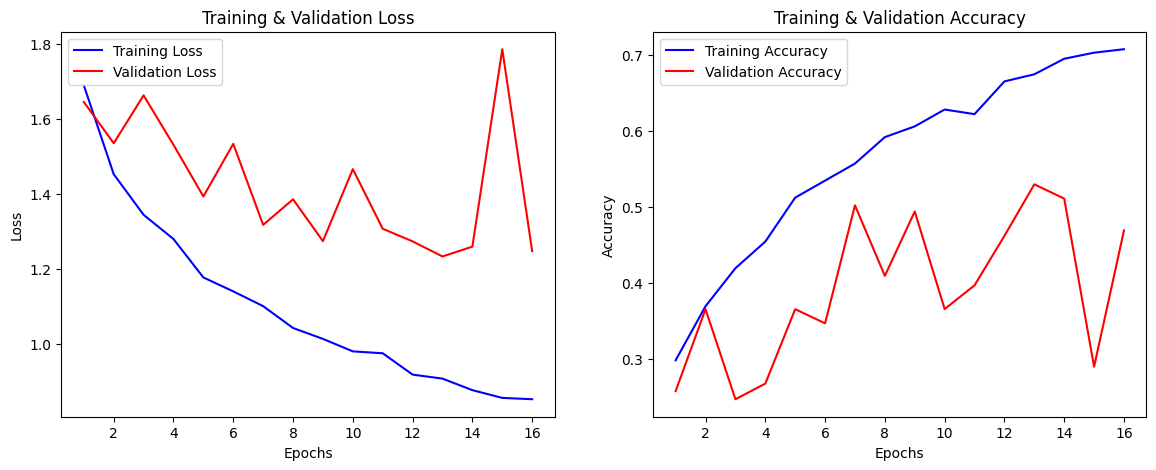

In [44]:
plot_training_curves(history)

In [46]:
from tensorflow.keras.regularizers import l2


In [51]:
def build_model_2(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(32, (3,3), activation=None, padding='same', 
                               kernel_regularizer=l2(0.01))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # 🔹 Dropout Added

    x = tf.keras.layers.Conv2D(64, (3,3), activation=None, padding='same',
                               kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # 🔹 Dropout Added

    x = tf.keras.layers.Conv2D(128, (3,3), activation=None, padding='same',
                               kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((2,2))(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # 🔹 Dropout Added

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation=None, kernel_regularizer=l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Dropout(0.6)(x)  # 🔹 Increased Dropout

    outputs = tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=l2(0.01))(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Create the model
model_2 = build_model_2(input_shape=(224, 224, 3))
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_2.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_32 (ReLU)                      │ (None, 224, 224, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_33               │ (None, 112, 112, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_33 (ReLU)                      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_25 (MaxPooling2D)      │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_34               │ (None, 56, 56, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_34 (ReLU)                      │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_35               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 12,940,356 (49.36 MB)

 Trainable params: 12,939,652 (49.36 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
history = model_2.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)


plot_training_curves(history)

Epoch 1/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 198ms/step - accuracy: 0.2483 - loss: 5.8439 - val_accuracy: 0.3714 - val_loss: 5.1477
Epoch 2/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 198ms/step - accuracy: 0.2841 - loss: 5.5222 - val_accuracy: 0.2857 - val_loss: 5.0882
Epoch 3/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.2767 - loss: 5.3068 - val_accuracy: 0.4000 - val_loss: 4.7380
Epoch 4/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 201ms/step - accuracy: 0.2994 - loss: 4.9865 - val_accuracy: 0.2286 - val_loss: 4.6723
Epoch 5/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.3157 - loss: 4.7274 - val_accuracy: 0.4286 - val_loss: 4.3089
Epoch 6/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 48s 200ms/step - accuracy: 0.3111 - loss: 4.4926 - val_accuracy: 0.2616 - val_loss: 4.2138
Epoch 7/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 199ms/step - accuracy: 0.3324 - loss: 4.2542 - val_accuracy: 0.1768 - val_loss: 4.0507
Epoch 8/50
144/144 ━━━━━━━━━━━━━━━━━━━━ 47s 197ms/step - accuracy: 0.3306 - loss: 4

### EfficientNet model fine tuning

---

### Performance Comparison

---